# Parser for HWDDDA Project

In [1]:
#! pip install pandas
#! pip install matplotlib
#! pip install vectormath
#! pip install pyvista
#! pip install vtk
#! pip install scipy

#interactive plots
%matplotlib notebook

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectormath as vmath
import pyvista as pv
from datetime import datetime, timedelta
import scipy.fftpack

import panel
panel.extension("vtk")
pv.set_plot_theme("document")

skiprows = 0 #used for ProcessData() to slide the start of the window

## LoadData() - read csv file and load it to a dataframe

Read the datafile and stick it in a data frame. Fixup a bunch of the data in the process (i.e. parse dates, calculate time per sample to interpolate the repeated timestamp blocks)

The data file starts with a calibration block (not currently parsing that calibration, just skipping it).

Since we have a bunch of data files, wrap this parsing into a function so we can cleanly call it once for each file.

Use either the stoprow or the rowcount. Stoprow takes precedence. This is meant to limit the loaded data, but still provide a workable dataset that can be diced up later and re-processed without reloading the whole file.

In [3]:
headerrowcount = 12
def LoadData(fname, startrow=0, stoprow=999999999999, rowcount=-1):
    filename = "../../data/preliminary/" + fname
    def f(s): #need to left pad the milliseconds
        if(len(s) != 21): #the string length (should) only vary by the last 3 characters, i.e. ms
            s = s[0:s.rfind(":")] + ":" + s[s.rfind(":")+1:].zfill(3)
        return pd.to_datetime(s, format="%m/%d/%y-%H:%M:%S:%f", errors="raise")

    if rowcount > 0: #update the stoprow if we were passed a valid rowcount
        stoprow = startrow + rowcount
    
    #TODO: need to use readable column names to avoid confusion
    #pressure, temperature, voltage, accel1, accel2, accel3, strain gauge1, strain gauge2, strain gauge3
    headers = ["dt", "Sch", "Press", "Temp", "Volt", "AccX", "AccY", "AccZ", "Str1", "Str2", "Str3"]
    #headers = ["dt", "Sch", "Ch0", "Ch1", "Ch2", "Ch3", "Ch4", "Ch5", "Ch6", "Ch7", "Ch8"]#, "empty"]
    df = pd.read_csv(filename, 
                     header=None, names=headers, 
                     index_col=False, #deal with trailing comma shifting the columns
                     skiprows=headerrowcount+startrow,  #skip the calibration block for now
                     nrows=stoprow-startrow,
                     parse_dates=["dt"],
                     date_parser=f,
                     na_filter=False,
                     low_memory=False)
    
    print("# of rows:", len(df), "before dropping empty values")
    df.dropna(inplace=True)

    
    
    
    #add a counter column for easy plotting. Keep the index so we can narrow the plots (i.e. use the x value to remap this function's start/stop row).
    #maintain the excel row number so that we can easily find it in the raw file
    excelstartrow = headerrowcount + startrow + 1
    df.insert(loc=0, column="cnt", value=np.arange(start=excelstartrow, stop=len(df)+excelstartrow))
    
    #add a column for the millisecond of the given sample
    #NOTE: this is not backwards validated... just the time from beginning to the end
    #TODO: this is slightly flawed in that the arbitrary start/stop daetime isnt the actual timestamp of that specific record (need to back up to the first of the repeated timestamp value)
    #TODO: better interpolation is done in the block below... should use that to get totalms (see column totalmsalt)
    #TODO: probably ditch this calc in favor of totalmsalt below.
    
    totalms = (df["dt"][len(df)-1] - df["dt"][0]).total_seconds() * 1000
    if np.isnan(totalms):
        print("ERROR: couldnt determine total milliseconds. Check input file.")
    else:
        mspersample = totalms / len(df)
        #print(mspersample)
        df.insert(loc=1, column="totalms", value=np.arange(start=0, stop=totalms, step=mspersample))
    
    #iterate to fixup the time per sample calculated. This is sloppy and slow, but should be functional enough
    #this calculates the time per sample and interpolates the wallclock timestamp for the repeated timestamps in a block
    mspersample = []
    fixedts = []
    basets = np.nan # holds the base timestamp, i.e. the first timestamp in a block
    nextts = np.nan # holds the next timestamp, i.e. the value of the next block
    countts = 0     # holds the number of repeated timestamps for the current block
    countcurr = 0
    for index, row in df.iterrows():
        #print(index, "-------")
        if basets != row["dt"]: #the current timestamp changed, so we need to update a bunch of things for this block
            basets = row["dt"]  #update the current block's NEW timestamp
            countts = 0
            countcurr = 0
            #find the next timestamp and count the values
            for x in range(20): #limit to 20 to find the next new timestamp, just to bound the search
                dfindex = index + x
                if dfindex >= len(df): break #fell off the end
                
                if basets == df["dt"][dfindex]: #found a repeat
                    countts += 1 #count the repeated values (could also set to x)
                else: #found a new timestamp, so we're done
                    nextts = df["dt"][dfindex]
                    break
        else: #current timestamp didnt change, so just use the previously calculated values
            countcurr += 1
        msval = ((nextts - basets).total_seconds() * 1000) / countts
        mspersample.append(msval)
        fixedts.append(basets + timedelta(microseconds=(msval * 1000 * countcurr)))    
    
    
    #this is probably a more accurate reading of the totalms compared to the method above
    df.insert(loc=2, column="totalmsalt", value=np.cumsum(mspersample)-mspersample[0]) #hack to shift all the values back to start at zero
    
    df.insert(loc=3, column="mspersample", value=mspersample)
    df.insert(loc=4, column="fixedts", value=fixedts)
    
    print("# of rows:", len(df), "after processing")
    #print(df)
    #print(df.head(5))
    
    
    #check if the timestamps are strictly increasing
    if(df["dt"].is_monotonic_increasing == False):
        print("******************************************************************")
        print("* WARNING!!!!! timestamps are corrupt - not monotonic increasing *")
        print("******************************************************************")
    
    
    #new cleaner method
    #get the difference between adjacent rows in seconds
    df["dt_diff"] = (df["dt"] - df["dt"].shift(1))/np.timedelta64(1, "s")
    
    for index, row in df.iterrows():
        if(row["dt_diff"] > 1):
            print("Bad time diff:", "prev:", df["dt"][index-1], "Excel Row#", str(row["cnt"]-1))
            print("              ", "curr:", row["dt"], "Excel Row#", str(row["cnt"]), "Diff:", str(row["dt_diff"])+"s")
            print("")
    
    return(df)

## ProcessData() - Process the previously loaded dataframe into a new dataframe

Adds the following columns to a new dataframe (so we can reprocess the original without loading it back from disk): 

AccelCalibG[x/y/z]    AccelZeroedG[x/y/z]   Vel[x/y/z]

PosDelta[x/y/z] the change in position

Pos[x/y/z] the total position

In [4]:
def ProcessData(tmpdf, calib, skiprows=0, rowcount=99999999):
    dfcalib = df[skiprows:skiprows+rowcount].copy() #because we are going to dice up the dataframe, and we will likely want to re-process it
    print("Skipping", skiprows, "rows, starting at excel row #" + str(dfcalib["cnt"].iloc[0]), "---", dfcalib["dt"].iloc[0])
    
    #calibrate the values
    dfcalib["AccelCalibGX"] =  (df["AccX"] - calib["AccelZeroX"]) / calib["AccelGainX"]
    dfcalib["AccelCalibGY"] =  (df["AccY"] - calib["AccelZeroY"]) / calib["AccelGainY"]
    dfcalib["AccelCalibGZ"] =  (df["AccZ"] - calib["AccelZeroZ"]) / calib["AccelGainZ"]
    
    #Get the average over a larger swath (i.e. the full dataset loaded into df).
    calib["AccelMeanX"] = (df["AccX"].mean() - calib["AccelZeroX"]) / calib["AccelGainX"]
    calib["AccelMeanY"] = (df["AccY"].mean() - calib["AccelZeroY"]) / calib["AccelGainY"]
    calib["AccelMeanZ"] = (df["AccZ"].mean() - calib["AccelZeroZ"]) / calib["AccelGainZ"]
    
    #subtract off the mean to give zeroed calibrated G's with gravity removed
    dfcalib["AccelZeroedGX"] = dfcalib["AccelCalibGX"] - calib["AccelMeanX"]
    dfcalib["AccelZeroedGY"] = dfcalib["AccelCalibGY"] - calib["AccelMeanY"]
    dfcalib["AccelZeroedGZ"] = dfcalib["AccelCalibGZ"] - calib["AccelMeanZ"]
    
    #TODO: use the milliseconds per sample to calculate the actual velocity
    
    dfcalib["VelDeltaX"] = ((dfcalib["AccelZeroedGX"]+dfcalib["AccelZeroedGX"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886)
    dfcalib["VelDeltaY"] = ((dfcalib["AccelZeroedGY"]+dfcalib["AccelZeroedGY"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886)
    dfcalib["VelDeltaZ"] = ((dfcalib["AccelZeroedGZ"]+dfcalib["AccelZeroedGZ"].shift(1))/2 * (dfcalib["mspersample"] / 1000) * 386.0886)
    dfcalib["VelX"] = (dfcalib["VelDeltaX"]+calib["InitialVelX"]).cumsum()
    dfcalib["VelY"] = (dfcalib["VelDeltaY"]+calib["InitialVelY"]).cumsum()
    dfcalib["VelZ"] = (dfcalib["VelDeltaZ"]+calib["InitialVelZ"]).cumsum()
    
    dfcalib["PosDeltaX"] = dfcalib["VelX"] * dfcalib["mspersample"] / 1000
    dfcalib["PosDeltaY"] = dfcalib["VelY"] * dfcalib["mspersample"] / 1000
    dfcalib["PosDeltaZ"] = dfcalib["VelZ"] * dfcalib["mspersample"] / 1000
    dfcalib["PosX"] = dfcalib["PosDeltaX"].cumsum()
    dfcalib["PosY"] = dfcalib["PosDeltaY"].cumsum()
    dfcalib["PosZ"] = dfcalib["PosDeltaZ"].cumsum()
    
    return(dfcalib)

## PlotDataXXX() - Wrapper for some basic plotting.

In [5]:
def PlotDataRaw(_df, plotchannels):
    if(plotchannels == "accel"):
        _df.plot(kind="scatter", x="cnt", y="AccZ", title="Acc Z", color="green")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="AccX", title="Acc X", color="red")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="AccY", title="Acc Y", color="blue")
        plt.show()
    elif(plotchannels == "load"):
        _df.plot(kind="scatter", x="cnt", y="Str1", title="Strain 1 (Ch #6)", color="green")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="Str2", title="Strain 2 (Ch #7)", color="red")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="Str3", title="Strain 3 (Ch #8)", color="blue")
        plt.show()
    else:
        print("Ooops, plotchannels not supported:", plotchannels)

In [6]:
def PlotDataProcessed(_df, plotAll, vertline=None):
    if(plotAll == True):
        _df.plot(kind="scatter", x="cnt", y="VelZ", title="Velocity Z", color="green")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()
    _df.plot(kind="scatter", x="cnt", y="PosZ", title="Position Z", color="green")
    plt.axhline(y=0, color="gray", linestyle="-")
    if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
    plt.show()
    
    if(plotAll == True):
        _df.plot(kind="scatter", x="cnt", y="VelX", title="Velocity X", color="red")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="PosX", title="Position X", color="red")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()    
    
        _df.plot(kind="scatter", x="cnt", y="VelY", title="Velocity Y", color="blue")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()
        _df.plot(kind="scatter", x="cnt", y="PosY", title="Position Y", color="blue")
        plt.axhline(y=0, color="gray", linestyle="-")
        if(vertline != None): plt.axvline(x=vertline, color="gray", linestyle="-")
        plt.show()

## Actually load some data

Load data from the file. Only run one of these, or just make sure the last one is the one you want to use.

Try and get the start/stop row index to cover legitimate data (i.e. exclude bad startup and shutdown data if present).

We load the data here and then process it later so that we can operate on a subset of that data.

In [7]:
#df = LoadData("file_43_calibrated_20180516102829.csv") #this one has a bunch of empty values

In [8]:
#df = LoadData("File_18_1002_Calibrated_20190510135452.csv", 0, 100)

In [9]:
#df = LoadData("Thorman B-3/File_35_1002_Calibrated_20190801103404.csv", 8723, rowcount=5000)
#print(df)

calibration = {
    "AccelZeroX": 17288.88, #I'm not sure these are correct... See Lynn & Gabriel discussion.
    "AccelZeroY": 17217.23,
    "AccelZeroZ": 16897.29,
    
    "AccelGainX": 7314.35, 
    "AccelGainY": 7467.77, 
    "AccelGainZ": 7488.96,
    
    "AccelMeanX": np.nan, #update these in ProcessData()
    "AccelMeanY": np.nan,
    "AccelMeanZ": np.nan,
    
    "InitialVelX": 0, #the initial velocities should be zero, but it appears the bridle can wobble at BOS
    "InitialVelY": 0,
    "InitialVelZ": 0,
}

Load all the files in a directory. This is to validate data.

This should only be run to test all... if you want to test a single file, just load it normally.

In [10]:
#This should rarely be run. Its just for testing a group of files.
print("This may take a while...")
subdir = ""
for directory, subdirectories, files in os.walk("../../data/preliminary/"):
    for file in files:
        if file.endswith(".csv") and file.find("Parameters") == -1:
            filewithsubdir = subdir + file
            print("")
            print("Doing:", filewithsubdir)
            df = LoadData(filewithsubdir)
            print("DONE:", filewithsubdir)
            print("---------------------------------------")
    for name in subdirectories:
        #print("dir", name, directory)
        subdir = name + "/"

print("")
print("Done loading all files in this folder.")

This may take a while...

Doing: File_29_1002_Calibrated_20200710150408.csv
# of rows: 71760 before dropping empty values
# of rows: 71760 after processing
******************************************************************
* WARNING!!!!! timestamps are corrupt - not monotonic increasing *
******************************************************************
Bad time diff: prev: 2020-07-10 14:02:02.930000 Excel Row# 25
               curr: 2020-07-10 14:30:02.782000 Excel Row# 26 Diff: 1679.852s

Bad time diff: prev: 2020-07-10 14:32:07.994000 Excel Row# 7604
               curr: 2020-07-10 14:32:09.211000 Excel Row# 7605 Diff: 1.217s

Bad time diff: prev: 2020-07-10 14:32:25.994000 Excel Row# 8683
               curr: 2020-07-10 14:32:27.211000 Excel Row# 8684 Diff: 1.217s

Bad time diff: prev: 2020-07-10 14:32:43.993000 Excel Row# 9762
               curr: 2020-07-10 14:32:45.210000 Excel Row# 9763 Diff: 1.217s

Bad time diff: prev: 2020-07-10 14:33:01.992000 Excel Row# 10841
           

Bad time diff: prev: 2020-07-10 14:45:59 Excel Row# 57420
               curr: 2020-07-10 14:46:00.217000 Excel Row# 57421 Diff: 1.217s

DONE: File_29_1002_Calibrated_20200710150408.csv
---------------------------------------

Doing: File_15_1002_Calibrated_20190510134828.csv
# of rows: 182 before dropping empty values
# of rows: 182 after processing
Bad time diff: prev: 2019-05-10 11:10:00.233000 Excel Row# 38
               curr: 2019-05-10 11:10:59.831000 Excel Row# 39 Diff: 59.598s

Bad time diff: prev: 2019-05-10 11:10:59.831000 Excel Row# 51
               curr: 2019-05-10 11:11:59.831000 Excel Row# 52 Diff: 60.0s

Bad time diff: prev: 2019-05-10 11:11:59.831000 Excel Row# 64
               curr: 2019-05-10 11:12:59.831000 Excel Row# 65 Diff: 60.0s

Bad time diff: prev: 2019-05-10 11:12:59.831000 Excel Row# 77
               curr: 2019-05-10 11:13:59.830000 Excel Row# 78 Diff: 59.999s

Bad time diff: prev: 2019-05-10 11:13:59.830000 Excel Row# 90
               curr: 2019-05-10 1

Bad time diff: prev: 2018-04-04 12:11:44.780000 Excel Row# 571
               curr: 2018-04-04 12:11:57.777000 Excel Row# 572 Diff: 12.997s

Bad time diff: prev: 2018-04-04 12:11:57.777000 Excel Row# 584
               curr: 2018-04-04 12:12:10.774000 Excel Row# 585 Diff: 12.997s

Bad time diff: prev: 2018-04-04 12:12:10.774000 Excel Row# 597
               curr: 2018-04-04 12:12:23.770000 Excel Row# 598 Diff: 12.996s

Bad time diff: prev: 2018-04-04 12:12:23.770000 Excel Row# 610
               curr: 2018-04-04 12:12:36.767000 Excel Row# 611 Diff: 12.997s

Bad time diff: prev: 2018-04-04 12:12:36.767000 Excel Row# 623
               curr: 2018-04-04 12:12:49.763000 Excel Row# 624 Diff: 12.996s

Bad time diff: prev: 2018-04-04 12:12:49.763000 Excel Row# 636
               curr: 2018-04-04 12:13:02.760000 Excel Row# 637 Diff: 12.997s

Bad time diff: prev: 2018-04-04 12:13:02.760000 Excel Row# 649
               curr: 2018-04-04 12:13:15.756000 Excel Row# 650 Diff: 12.996s

Bad time diff

Bad time diff: prev: 2018-04-04 12:37:44.371000 Excel Row# 2131
               curr: 2018-04-04 12:37:57.367000 Excel Row# 2132 Diff: 12.996s

Bad time diff: prev: 2018-04-04 12:37:57.367000 Excel Row# 2144
               curr: 2018-04-04 12:38:10.364000 Excel Row# 2145 Diff: 12.997s

Bad time diff: prev: 2018-04-04 12:38:10.364000 Excel Row# 2157
               curr: 2018-04-04 12:38:23.360000 Excel Row# 2158 Diff: 12.996s

Bad time diff: prev: 2018-04-04 12:38:23.360000 Excel Row# 2170
               curr: 2018-04-04 12:38:36.357000 Excel Row# 2171 Diff: 12.997s

Bad time diff: prev: 2018-04-04 12:38:36.357000 Excel Row# 2183
               curr: 2018-04-04 12:38:49.354000 Excel Row# 2184 Diff: 12.997s

Bad time diff: prev: 2018-04-04 12:38:49.354000 Excel Row# 2196
               curr: 2018-04-04 12:39:02.350000 Excel Row# 2197 Diff: 12.996s

Bad time diff: prev: 2018-04-04 12:39:02.350000 Excel Row# 2209
               curr: 2018-04-04 12:39:15.347000 Excel Row# 2210 Diff: 12.997s


Bad time diff: prev: 2018-04-04 13:00:29.012000 Excel Row# 3496
               curr: 2018-04-04 13:00:42.009000 Excel Row# 3497 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:00:42.009000 Excel Row# 3509
               curr: 2018-04-04 13:00:55.005000 Excel Row# 3510 Diff: 12.996s

Bad time diff: prev: 2018-04-04 13:00:55.005000 Excel Row# 3522
               curr: 2018-04-04 13:01:08.002000 Excel Row# 3523 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:01:08.002000 Excel Row# 3535
               curr: 2018-04-04 13:01:20.999000 Excel Row# 3536 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:01:20.999000 Excel Row# 3548
               curr: 2018-04-04 13:01:33.995000 Excel Row# 3549 Diff: 12.996s

Bad time diff: prev: 2018-04-04 13:01:33.995000 Excel Row# 3561
               curr: 2018-04-04 13:01:46.992000 Excel Row# 3562 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:01:46.992000 Excel Row# 3574
               curr: 2018-04-04 13:01:59.988000 Excel Row# 3575 Diff: 12.996s


Bad time diff: prev: 2018-04-04 13:21:55.674000 Excel Row# 4783
               curr: 2018-04-04 13:22:08.671000 Excel Row# 4784 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:22:08.671000 Excel Row# 4796
               curr: 2018-04-04 13:22:21.667000 Excel Row# 4797 Diff: 12.996s

Bad time diff: prev: 2018-04-04 13:22:21.667000 Excel Row# 4809
               curr: 2018-04-04 13:22:34.664000 Excel Row# 4810 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:22:34.664000 Excel Row# 4822
               curr: 2018-04-04 13:22:47.661000 Excel Row# 4823 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:22:47.661000 Excel Row# 4835
               curr: 2018-04-04 13:23:00.657000 Excel Row# 4836 Diff: 12.996s

Bad time diff: prev: 2018-04-04 13:23:00.657000 Excel Row# 4848
               curr: 2018-04-04 13:23:13.654000 Excel Row# 4849 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:23:13.654000 Excel Row# 4861
               curr: 2018-04-04 13:23:26.650000 Excel Row# 4862 Diff: 12.996s


Bad time diff: prev: 2018-04-04 13:46:50.282000 Excel Row# 6278
               curr: 2018-04-04 13:47:03.278000 Excel Row# 6279 Diff: 12.996s

Bad time diff: prev: 2018-04-04 13:47:03.278000 Excel Row# 6291
               curr: 2018-04-04 13:47:16.275000 Excel Row# 6292 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:47:16.275000 Excel Row# 6304
               curr: 2018-04-04 13:47:29.271000 Excel Row# 6305 Diff: 12.996s

Bad time diff: prev: 2018-04-04 13:47:29.271000 Excel Row# 6317
               curr: 2018-04-04 13:47:42.268000 Excel Row# 6318 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:47:42.268000 Excel Row# 6330
               curr: 2018-04-04 13:47:55.265000 Excel Row# 6331 Diff: 12.997s

Bad time diff: prev: 2018-04-04 13:47:55.265000 Excel Row# 6343
               curr: 2018-04-04 13:48:08.261000 Excel Row# 6344 Diff: 12.996s

Bad time diff: prev: 2018-04-04 13:48:08.261000 Excel Row# 6356
               curr: 2018-04-04 13:48:21.258000 Excel Row# 6357 Diff: 12.997s


Bad time diff: prev: 2018-04-04 14:09:47.920000 Excel Row# 7656
               curr: 2018-04-04 14:10:00.916000 Excel Row# 7657 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:10:00.916000 Excel Row# 7669
               curr: 2018-04-04 14:10:13.913000 Excel Row# 7670 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:10:13.913000 Excel Row# 7682
               curr: 2018-04-04 14:10:26.909000 Excel Row# 7683 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:10:26.909000 Excel Row# 7695
               curr: 2018-04-04 14:10:39.906000 Excel Row# 7696 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:10:39.906000 Excel Row# 7708
               curr: 2018-04-04 14:10:52.903000 Excel Row# 7709 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:10:52.903000 Excel Row# 7721
               curr: 2018-04-04 14:11:05.899000 Excel Row# 7722 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:11:05.899000 Excel Row# 7734
               curr: 2018-04-04 14:11:18.896000 Excel Row# 7735 Diff: 12.997s


Bad time diff: prev: 2018-04-04 14:32:58.554000 Excel Row# 9047
               curr: 2018-04-04 14:33:11.551000 Excel Row# 9048 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:33:11.551000 Excel Row# 9060
               curr: 2018-04-04 14:33:24.548000 Excel Row# 9061 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:33:24.548000 Excel Row# 9073
               curr: 2018-04-04 14:33:37.544000 Excel Row# 9074 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:33:37.544000 Excel Row# 9086
               curr: 2018-04-04 14:33:50.541000 Excel Row# 9087 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:33:50.541000 Excel Row# 9099
               curr: 2018-04-04 14:34:03.537000 Excel Row# 9100 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:34:03.537000 Excel Row# 9112
               curr: 2018-04-04 14:34:16.534000 Excel Row# 9113 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:34:16.534000 Excel Row# 9125
               curr: 2018-04-04 14:34:29.531000 Excel Row# 9126 Diff: 12.997s


Bad time diff: prev: 2018-04-04 14:54:12.220000 Excel Row# 10321
               curr: 2018-04-04 14:54:25.216000 Excel Row# 10322 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:54:25.216000 Excel Row# 10334
               curr: 2018-04-04 14:54:38.213000 Excel Row# 10335 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:54:38.213000 Excel Row# 10347
               curr: 2018-04-04 14:54:51.210000 Excel Row# 10348 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:54:51.210000 Excel Row# 10360
               curr: 2018-04-04 14:55:04.206000 Excel Row# 10361 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:55:04.206000 Excel Row# 10373
               curr: 2018-04-04 14:55:17.203000 Excel Row# 10374 Diff: 12.997s

Bad time diff: prev: 2018-04-04 14:55:17.203000 Excel Row# 10386
               curr: 2018-04-04 14:55:30.199000 Excel Row# 10387 Diff: 12.996s

Bad time diff: prev: 2018-04-04 14:55:30.199000 Excel Row# 10399
               curr: 2018-04-04 14:55:43.196000 Excel Row# 10400 

Bad time diff: prev: 2018-04-04 15:07:38.008000 Excel Row# 11127
               curr: 2018-04-04 15:07:51.005000 Excel Row# 11128 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:07:51.005000 Excel Row# 11140
               curr: 2018-04-04 15:08:04.001000 Excel Row# 11141 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:08:04.001000 Excel Row# 11153
               curr: 2018-04-04 15:08:16.998000 Excel Row# 11154 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:08:16.998000 Excel Row# 11166
               curr: 2018-04-04 15:08:29.995000 Excel Row# 11167 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:08:29.995000 Excel Row# 11179
               curr: 2018-04-04 15:08:42.991000 Excel Row# 11180 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:08:42.991000 Excel Row# 11192
               curr: 2018-04-04 15:08:55.988000 Excel Row# 11193 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:08:55.988000 Excel Row# 11205
               curr: 2018-04-04 15:09:08.984000 Excel Row# 11206 

               curr: 2018-04-04 15:31:40.629000 Excel Row# 12558 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:31:40.629000 Excel Row# 12570
               curr: 2018-04-04 15:31:53.626000 Excel Row# 12571 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:31:53.626000 Excel Row# 12583
               curr: 2018-04-04 15:32:06.622000 Excel Row# 12584 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:32:06.622000 Excel Row# 12596
               curr: 2018-04-04 15:32:19.619000 Excel Row# 12597 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:32:19.619000 Excel Row# 12609
               curr: 2018-04-04 15:32:32.616000 Excel Row# 12610 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:32:32.616000 Excel Row# 12622
               curr: 2018-04-04 15:32:45.612000 Excel Row# 12623 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:32:45.612000 Excel Row# 12635
               curr: 2018-04-04 15:32:58.609000 Excel Row# 12636 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:32:58.609000 Ex

Bad time diff: prev: 2018-04-04 15:54:51.264000 Excel Row# 13961
               curr: 2018-04-04 15:55:04.261000 Excel Row# 13962 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:55:04.261000 Excel Row# 13974
               curr: 2018-04-04 15:55:17.257000 Excel Row# 13975 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:55:17.257000 Excel Row# 13987
               curr: 2018-04-04 15:55:30.254000 Excel Row# 13988 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:55:30.254000 Excel Row# 14000
               curr: 2018-04-04 15:55:43.250000 Excel Row# 14001 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:55:43.250000 Excel Row# 14013
               curr: 2018-04-04 15:55:56.247000 Excel Row# 14014 Diff: 12.997s

Bad time diff: prev: 2018-04-04 15:55:56.247000 Excel Row# 14026
               curr: 2018-04-04 15:56:09.243000 Excel Row# 14027 Diff: 12.996s

Bad time diff: prev: 2018-04-04 15:56:09.243000 Excel Row# 14039
               curr: 2018-04-04 15:56:22.240000 Excel Row# 14040 

# of rows: 35932 before dropping empty values
# of rows: 35932 after processing
******************************************************************
* WARNING!!!!! timestamps are corrupt - not monotonic increasing *
******************************************************************
Bad time diff: prev: 2019-06-28 16:41:21 Excel Row# 22320
               curr: 2019-06-28 16:41:22.217000 Excel Row# 22321 Diff: 1.217s

DONE: Thorman B-3/File_33_1002_Calibrated_20190801103854.csv
---------------------------------------

Doing: Thorman B-3/File_34_1002_Calibrated_20190801103833.csv
# of rows: 104 before dropping empty values
# of rows: 104 after processing
Bad time diff: prev: 2019-06-28 16:45:09.919000 Excel Row# 25
               curr: 2019-06-28 16:46:09.387000 Excel Row# 26 Diff: 59.468s

Bad time diff: prev: 2019-06-28 16:46:09.387000 Excel Row# 38
               curr: 2019-06-28 16:47:09.386000 Excel Row# 39 Diff: 59.999s

Bad time diff: prev: 2019-06-28 16:47:09.386000 Excel Row# 51
  

In [11]:
#calibration run
df = LoadData("File_29_1002_Calibrated_20200710150408.csv", 12400, 13200)
#df = LoadData("file_43_calibrated_20180516102829.csv")
#df = LoadData("Thorman B-3/File_32_1002_Calibrated_20190801104155.csv")
#df = LoadData("File_15_1002_Calibrated_20190510134828.csv")

#dfprocessed = ProcessData(df, calibration, skiprows=n, rowcount=tmpRowCount)


# of rows: 800 before dropping empty values
# of rows: 800 after processing
******************************************************************
* WARNING!!!!! timestamps are corrupt - not monotonic increasing *
******************************************************************
Bad time diff: prev: 2020-07-10 14:33:37.991000 Excel Row# 12999
               curr: 2020-07-10 14:33:39.208000 Excel Row# 13000 Diff: 1.217s



## --------------------------
This is for the frequency analysis stuff on the load channels. A lot of the processing below this section was for calibration of the accelerometer

NOTE: this is on the unprocessed data (df)

TODO: find the optimal window for analysis

TODO: frequency analysis

In [12]:
df.describe() #get some stats from the original unprocessed data

cnt       totalms    totalmsalt  mspersample    Sch  \
count    800.0000    800.000000    800.000000   800.000000  800.0   
mean   12812.5000   6714.596250   6820.969375    16.807500    1.0   
std      231.0844   3883.951056   3919.192615    14.682304    0.0   
min    12413.0000      0.000000      0.000000   -60.307692    1.0   
25%    12612.7500   3357.298125   3424.096154    16.692308    1.0   
50%    12812.5000   6714.596250   6756.384615    16.692308    1.0   
75%    13012.2500  10071.894375  10888.769231    16.692308    1.0   
max    13212.0000  13429.192500  13337.500000   108.500000    1.0   

             Press          Temp         Volt          AccX          AccY  \
count   800.000000    800.000000   800.000000    800.000000    800.000000   
mean   1006.688750  17736.095000  7980.814213  17738.592500  17856.487500   
std       1.129588      1.630736     1.900096     11.222472     20.701704   
min    1001.000000  17728.000000  7976.910000  17666.000000  17728.000000   
25%    1006.000000  17736.000000  7978.440000  17733.000000  17845.000000   
50%    1007.000000  17736.000000  7982.540000  17740.000000  17857.000000   
75%    1008.000000  17736.000000  7982.540000  17745.000000  17868.000000   
max    1008.000000  17742.000000  7983.060000  17798.000000  17942.000000   

              AccZ          Str1          Str2          Str3     dt_diff  
count   800.000000    800.000000    800.000000    800.000000  799.000000  
mean   9758.531250  10158.973750  11561.982500  10808.356250    0.016829  
std       8.545045      5.206433      6.694828     18.503238    0.076677  
min    9737.000000  10144.000000  11548.000000  10779.000000   -0.784000  
25%    9752.000000  10155.000000  11557.000000  10795.000000    0.000000  
50%    9757.000000  10159.000000  11561.000000  10801.000000    0.000000  
75%    9765.000000  10163.000000  11566.000000  10817.000000    0.000000  
max    9808.000000  10173.000000  11591.000000  10858.000000    1.217000

<IPython.core.display.Javascript object>


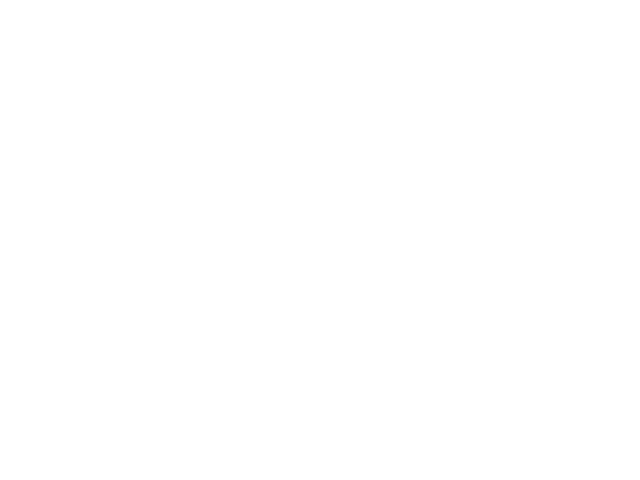

<IPython.core.display.Javascript object>


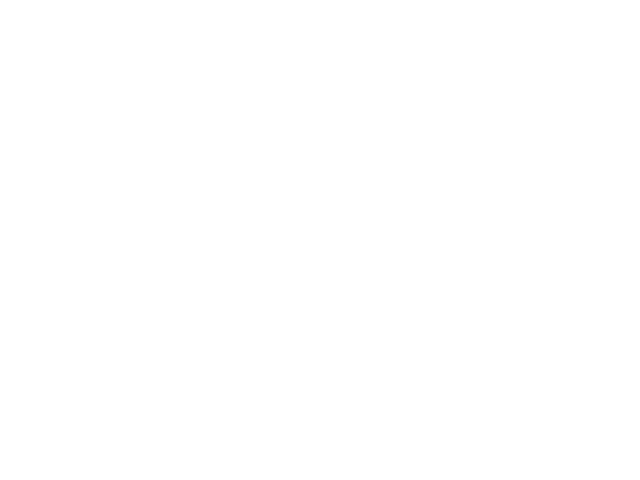

<IPython.core.display.Javascript object>


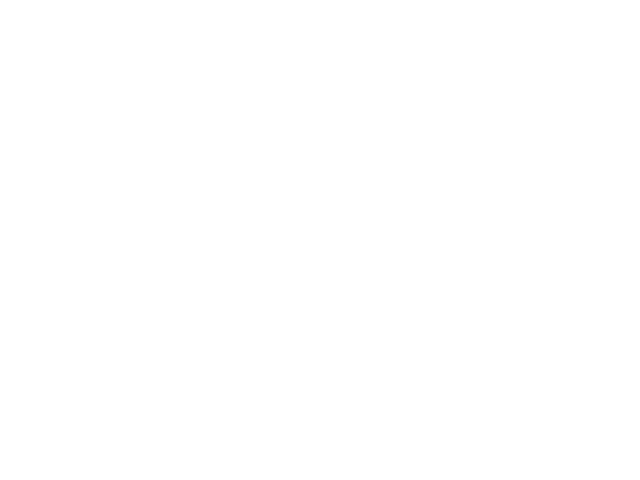

In [13]:
PlotDataRaw(df, "load")

<IPython.core.display.Javascript object>


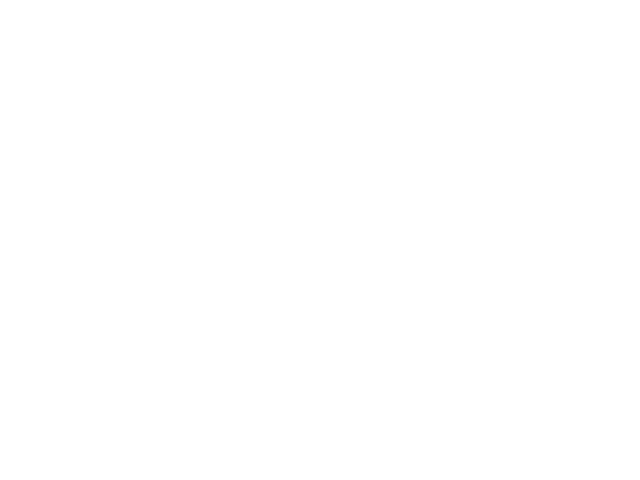

<IPython.core.display.Javascript object>


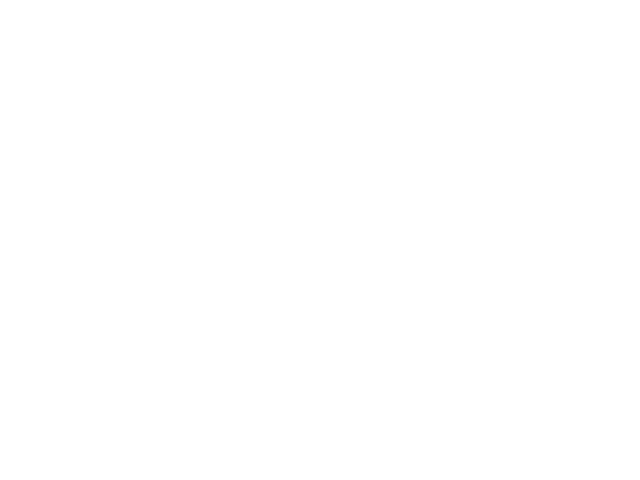

<IPython.core.display.Javascript object>


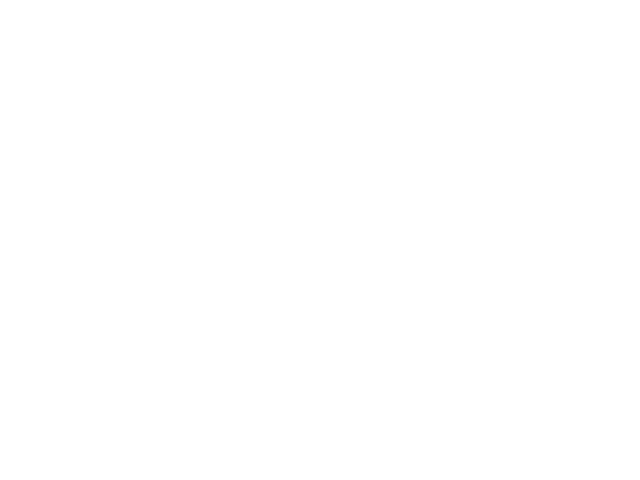

In [14]:
#maybe theres some mechanical vibration going on?
PlotDataRaw(df, "accel")

samples per second: 59.49724825226833 samples
seconds per sample: 0.0168075 seconds
sample range timespan: 13.446 seconds


<IPython.core.display.Javascript object>


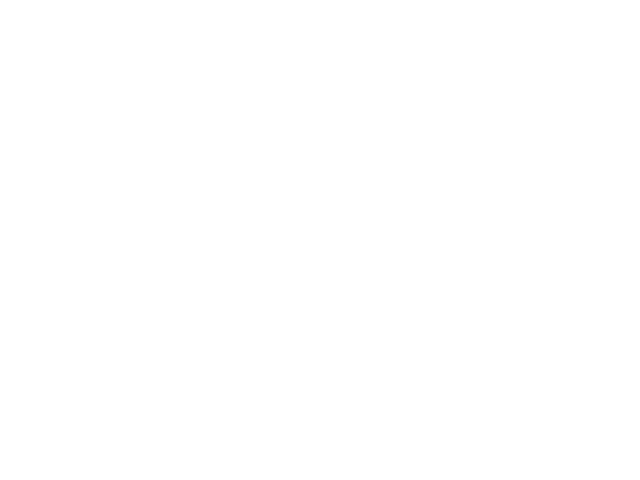

<IPython.core.display.Javascript object>


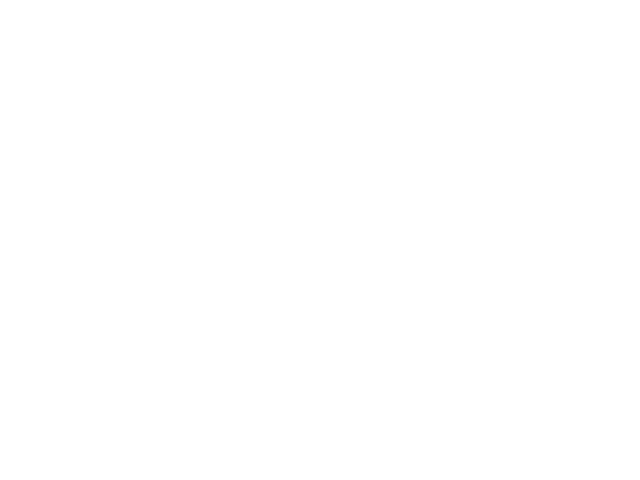

<IPython.core.display.Javascript object>


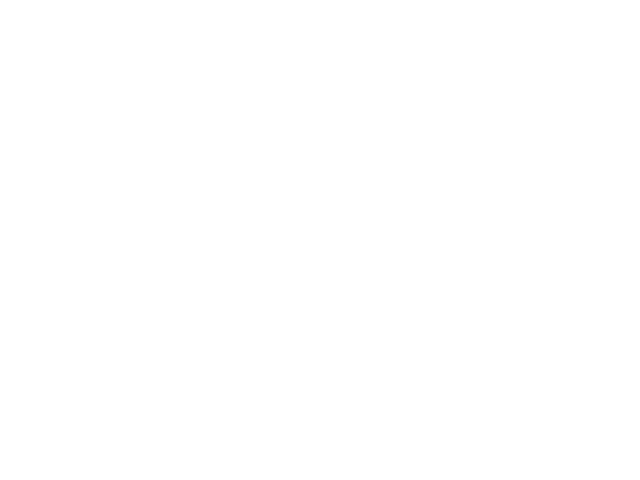

In [15]:
yf = scipy.fft.fft(df["Str1"].values)
freq = scipy.fft.fftfreq(len(yf), df["mspersample"].mean()/1000.0)

print("samples per second:", 1000.0/df["mspersample"].mean(), "samples")
print("seconds per sample:", df["mspersample"].mean()/1000.0, "seconds")
print("sample range timespan:", (df["mspersample"].mean()*len(yf))/1000.0, "seconds")

fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="green")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1000)
plt.show()

yf = scipy.fft.fft(df["Str2"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="red")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1000)
plt.show()

yf = scipy.fft.fft(df["Str3"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="blue")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1000)
plt.show()

<IPython.core.display.Javascript object>


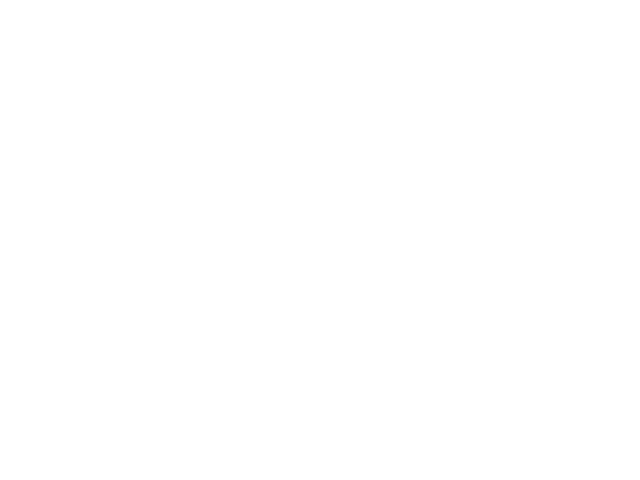

<IPython.core.display.Javascript object>


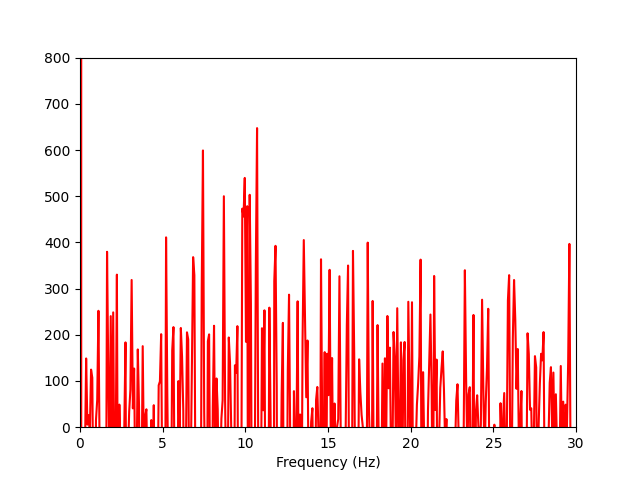

<IPython.core.display.Javascript object>


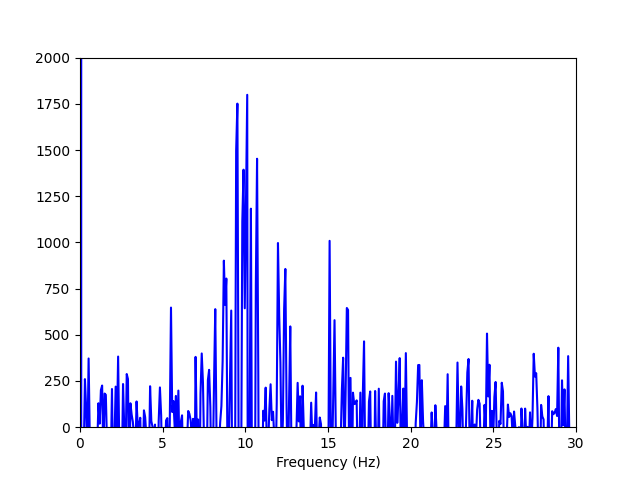

In [16]:
yf = scipy.fft.fft(df["AccZ"].values)
freq = scipy.fft.fftfreq(len(yf), df["mspersample"].mean()/1000.0)

fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="green")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 600)
plt.show()

yf = scipy.fft.fft(df["AccX"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="red")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 800)
plt.show()

yf = scipy.fft.fft(df["AccY"].values)
fig, ax = plt.subplots()
ax.plot(freq, yf.real, color="blue")
ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 2000)
plt.show()

## --------------------------
Stuff below here was for the accelerometer ===> position
## --------------------------

## Visually find the optimal start sample

Use this to plot a bunch of calcs from varying starting samples. You can then quickly scan the plots to find the one where the position returns to zero.

All the position plots start at zero on the left (because that is our "assumed" boundry condition), but in reality the mechanical system is not actually at zero. The plot that returns to zero at the right is "likely" to have picked the correct starting sample where the mechanical system was actually at zero.

Once you find a good starting row number, you can use the next cell to further narrow it down.

<span style="color:blue"><b>Key point:</b> Find the plot that crosses the zero line on the right side</span>.

Processing a window of 600 samples, sliding at incriments of 10 records
The first record in this data set is excel row #12413
Skipping 0 rows, starting at excel row #12413 --- 2020-07-10 14:33:28.232000


<IPython.core.display.Javascript object>


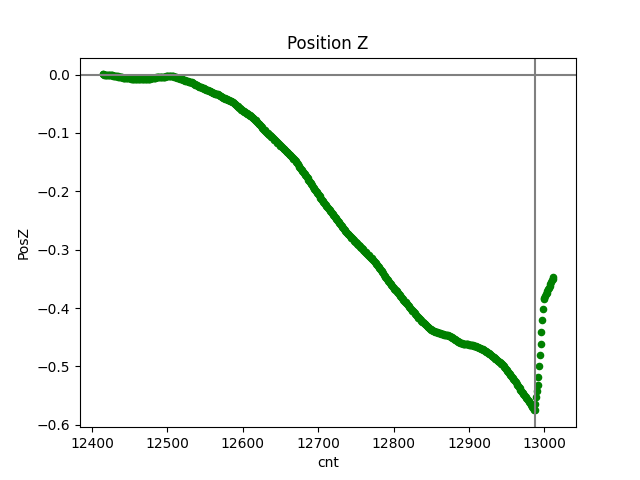

Skipping 10 rows, starting at excel row #12423 --- 2020-07-10 14:33:28.449000


<IPython.core.display.Javascript object>


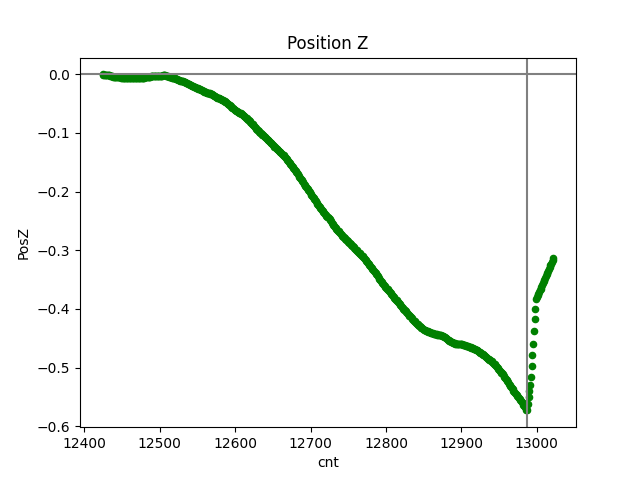

Skipping 20 rows, starting at excel row #12433 --- 2020-07-10 14:33:28.666000


<IPython.core.display.Javascript object>


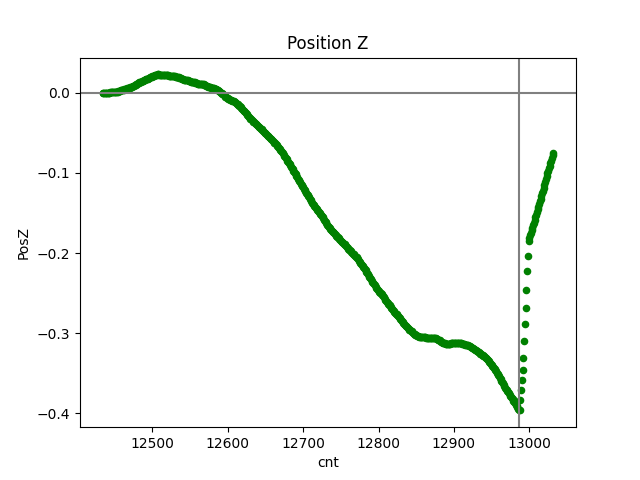

Skipping 30 rows, starting at excel row #12443 --- 2020-07-10 14:33:28.883000


<IPython.core.display.Javascript object>


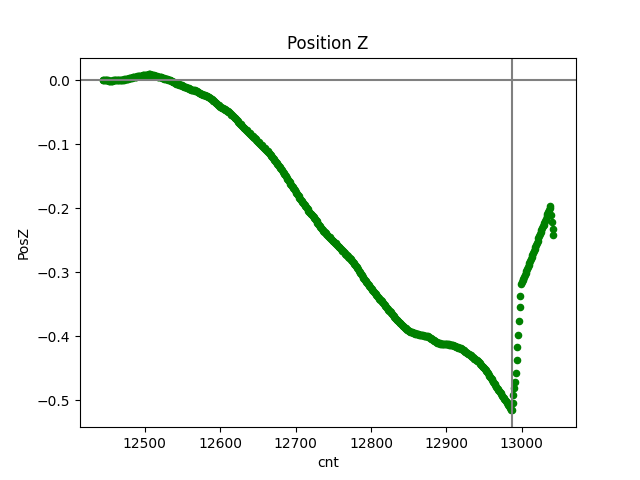

Skipping 40 rows, starting at excel row #12453 --- 2020-07-10 14:33:28.883000


<IPython.core.display.Javascript object>


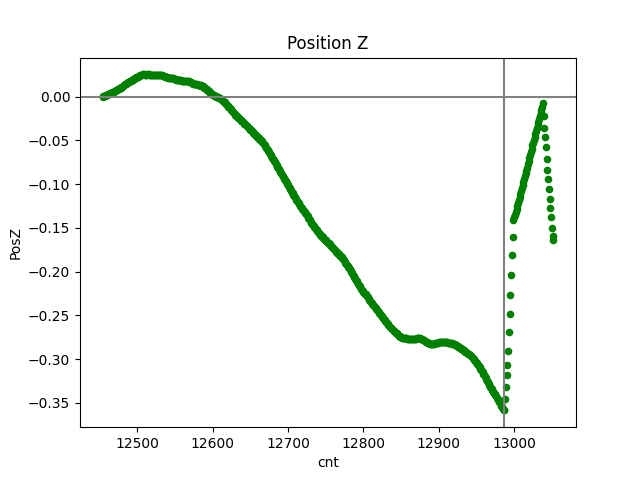

Skipping 50 rows, starting at excel row #12463 --- 2020-07-10 14:33:29.100000


<IPython.core.display.Javascript object>


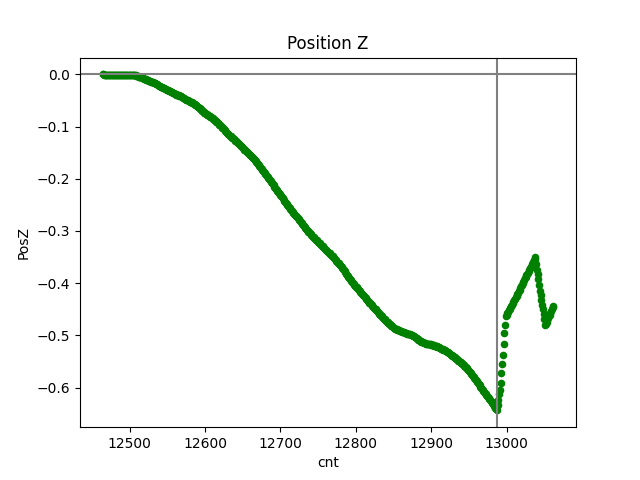

Skipping 60 rows, starting at excel row #12473 --- 2020-07-10 14:33:29.317000


<IPython.core.display.Javascript object>


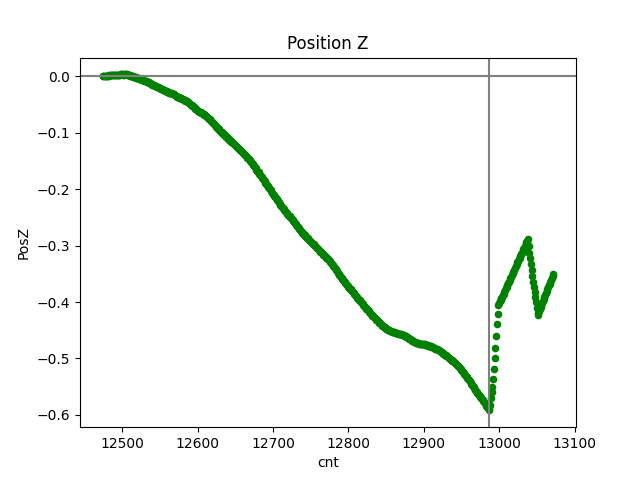

Skipping 70 rows, starting at excel row #12483 --- 2020-07-10 14:33:29.534000


<IPython.core.display.Javascript object>


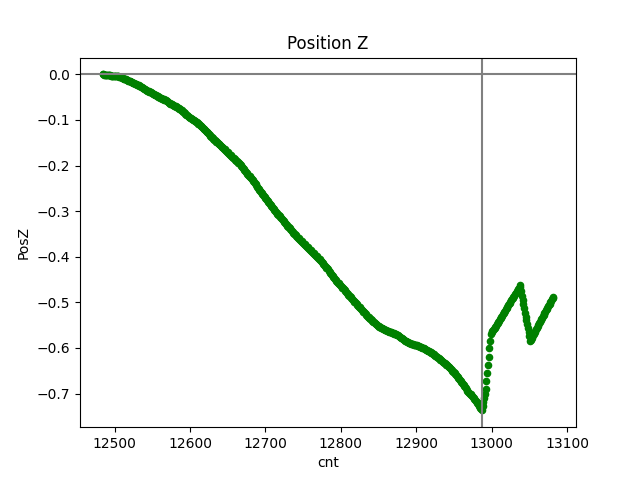

Skipping 80 rows, starting at excel row #12493 --- 2020-07-10 14:33:29.750000


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<IPython.core.display.Javascript object>


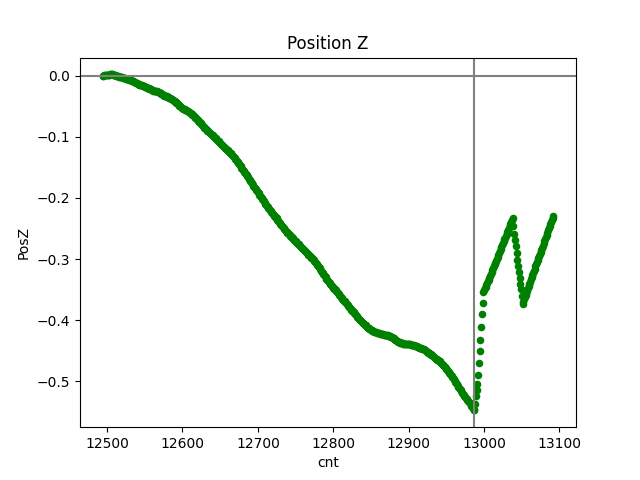

Skipping 90 rows, starting at excel row #12503 --- 2020-07-10 14:33:29.750000


<IPython.core.display.Javascript object>


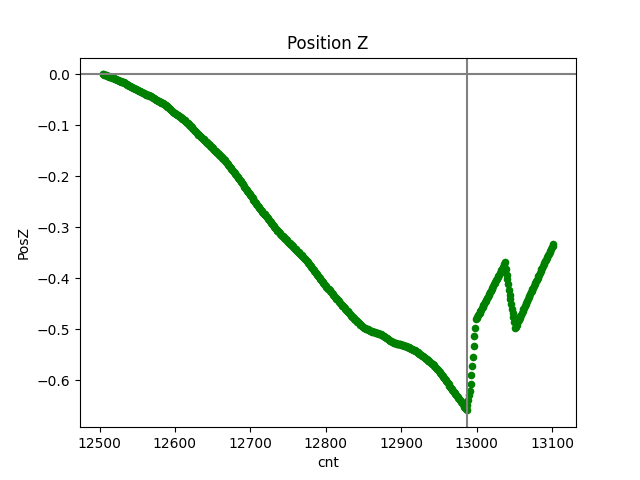

Skipping 100 rows, starting at excel row #12513 --- 2020-07-10 14:33:29.967000


<IPython.core.display.Javascript object>


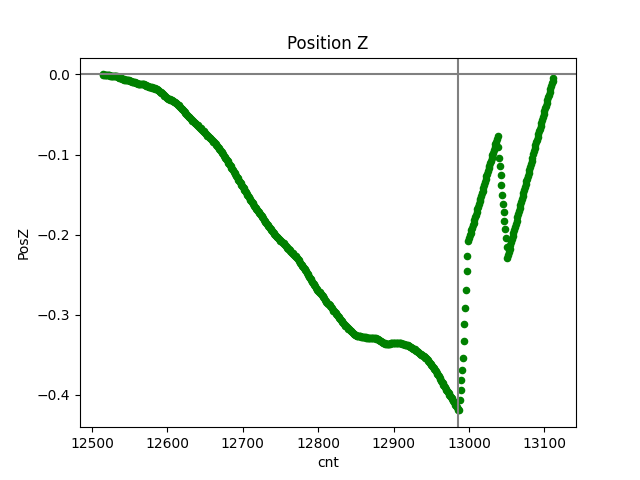

Skipping 110 rows, starting at excel row #12523 --- 2020-07-10 14:33:30.184000


<IPython.core.display.Javascript object>


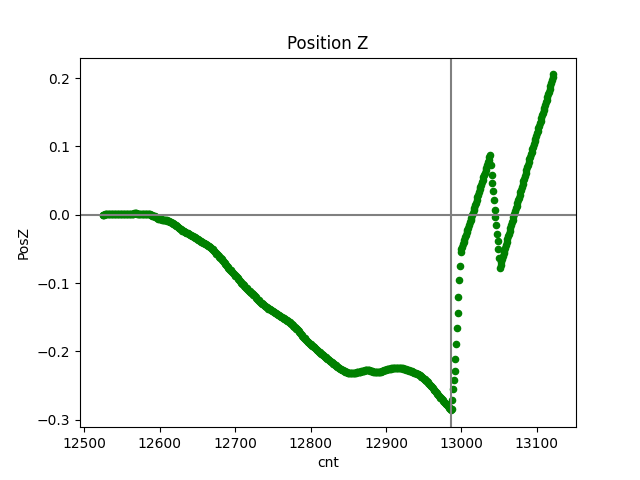

Skipping 120 rows, starting at excel row #12533 --- 2020-07-10 14:33:30.401000


<IPython.core.display.Javascript object>


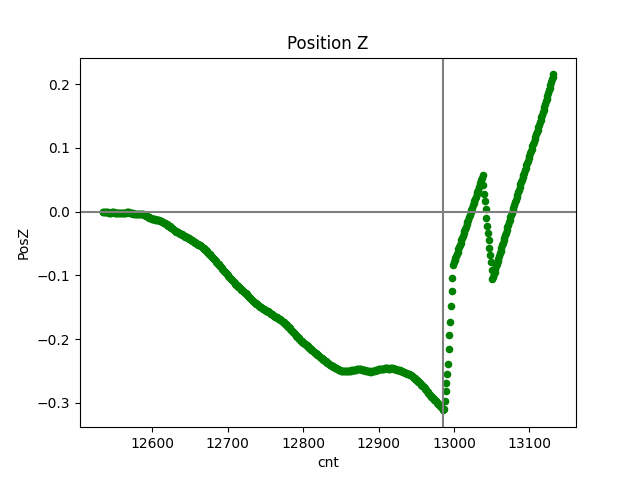

Skipping 130 rows, starting at excel row #12543 --- 2020-07-10 14:33:30.401000


<IPython.core.display.Javascript object>


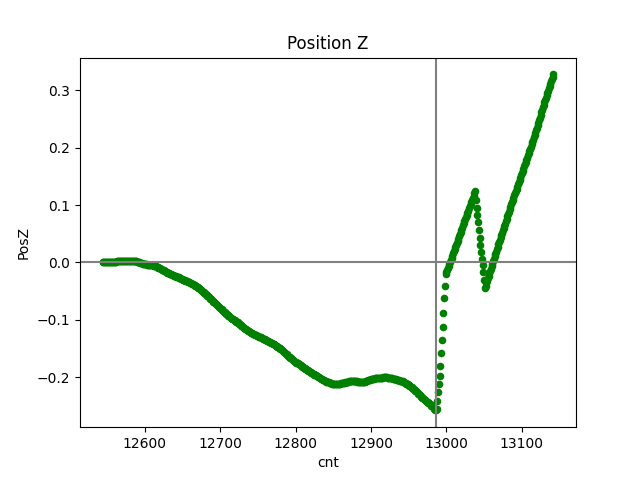

Skipping 140 rows, starting at excel row #12553 --- 2020-07-10 14:33:30.618000


<IPython.core.display.Javascript object>


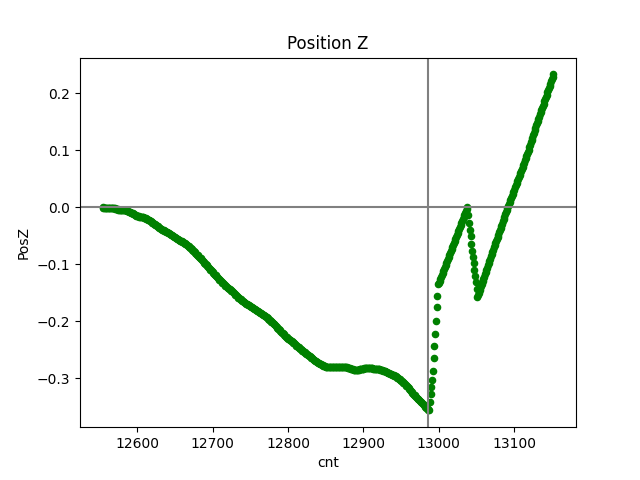

Skipping 150 rows, starting at excel row #12563 --- 2020-07-10 14:33:30.835000


<IPython.core.display.Javascript object>


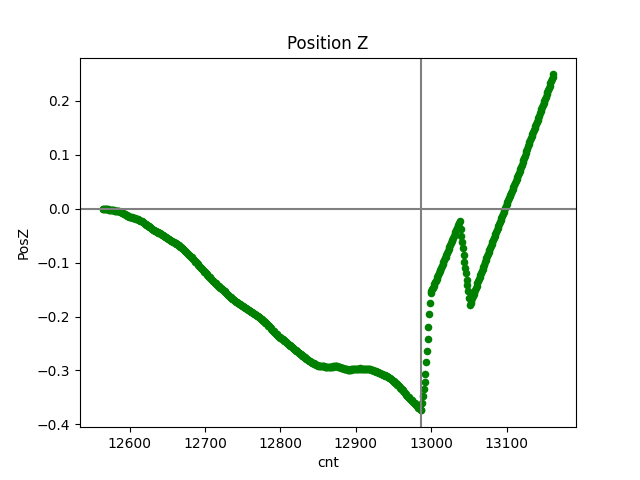

Skipping 160 rows, starting at excel row #12573 --- 2020-07-10 14:33:31.052000


<IPython.core.display.Javascript object>


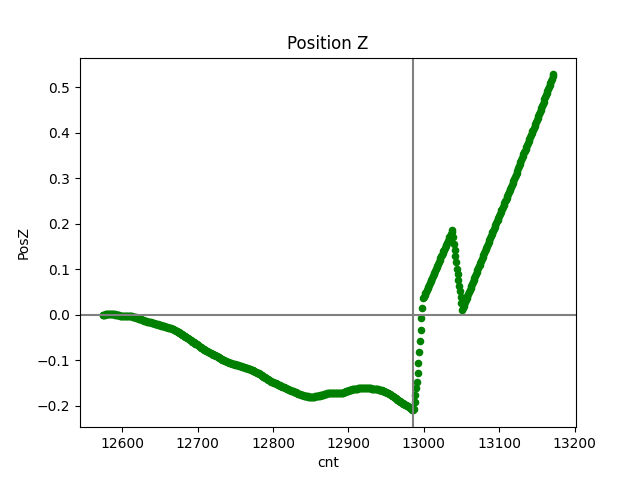

Skipping 170 rows, starting at excel row #12583 --- 2020-07-10 14:33:31.052000


<IPython.core.display.Javascript object>


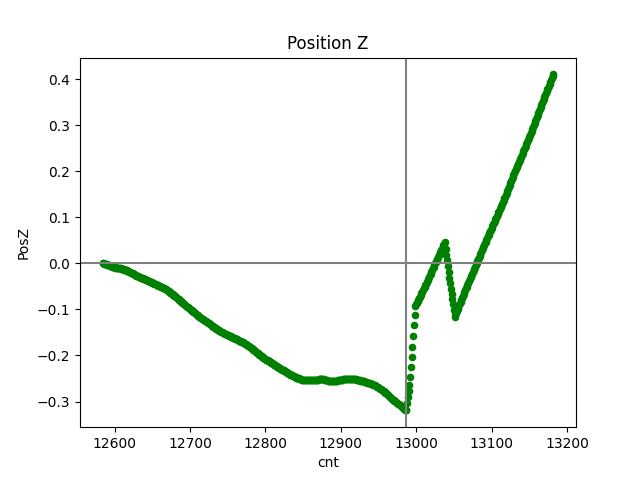

Skipping 180 rows, starting at excel row #12593 --- 2020-07-10 14:33:31.268000


<IPython.core.display.Javascript object>


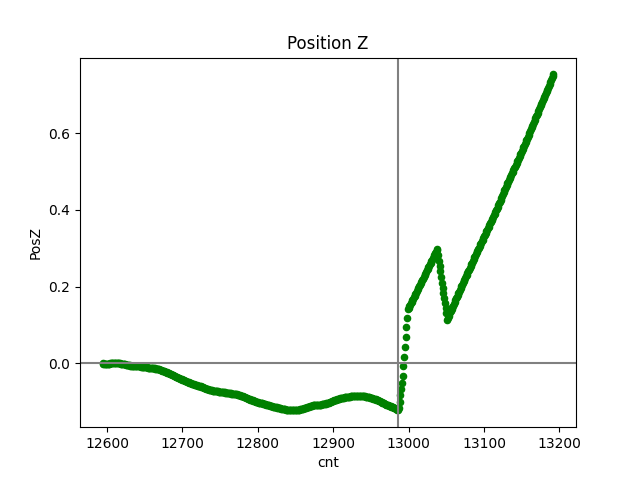

Skipping 190 rows, starting at excel row #12603 --- 2020-07-10 14:33:31.485000


<IPython.core.display.Javascript object>


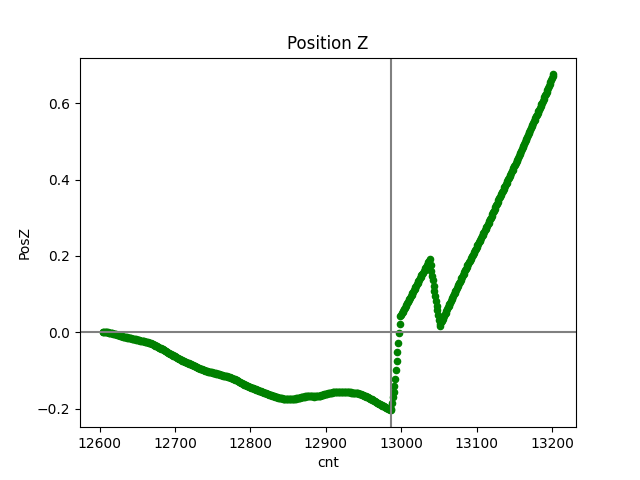

In [17]:
tmpStep = 10 #each plot will start at n*step
tmpLast = 200 #the last row where the plotting loop stops
tmpRowCount = 600 #make sure this spans at least one stroke

#NOTE: in this example, the plot returns to zero somewhere between 150 & 160 - see the plots below

print("Processing a window of", tmpRowCount, "samples, sliding at incriments of", tmpStep, "records")
print("The first record in this data set is excel row #" + str(df["cnt"].iloc[0]))

for n in range(0, tmpLast, tmpStep):
    dfprocessed = ProcessData(df, calibration, skiprows=n, rowcount=tmpRowCount)
    rightlocalminidx = dfprocessed["PosZ"].iloc[int(tmpRowCount/2):].idxmin()
    minvelcnt = dfprocessed["cnt"][rightlocalminidx]
    
    #check if the local minimum on the right isnt good. There are probably better methods for this (like it should follow the global maximum)
    if(rightlocalminidx == int(tmpRowCount/2)+n):
        minvelcnt = None
    
    PlotDataProcessed(dfprocessed, False, vertline=minvelcnt)

Skipping 153 rows, starting at excel row #12566 --- 2020-07-10 14:33:30.835000


<IPython.core.display.Javascript object>


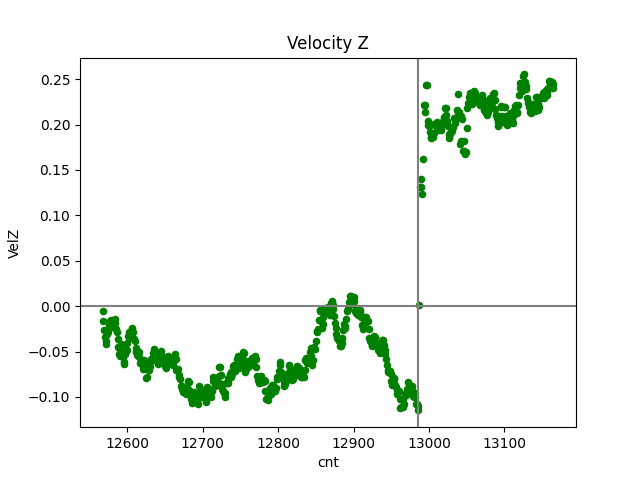

<IPython.core.display.Javascript object>


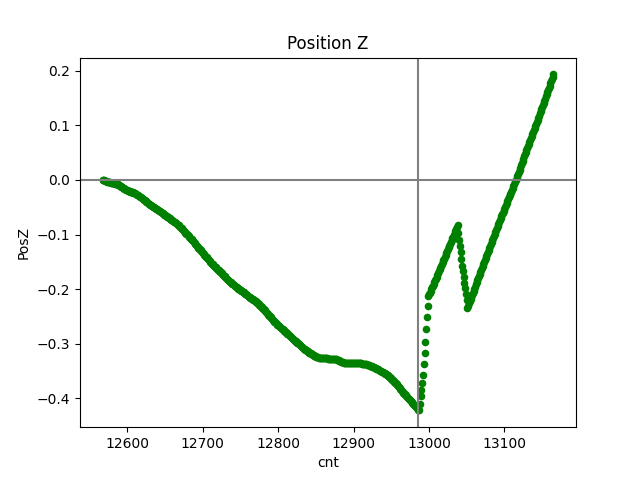

<IPython.core.display.Javascript object>


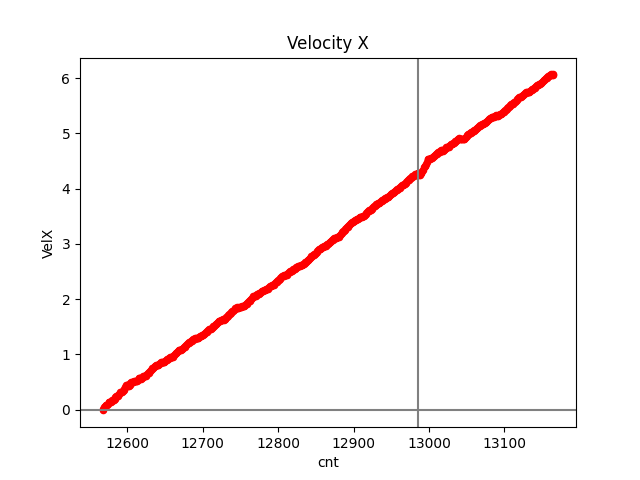

<IPython.core.display.Javascript object>


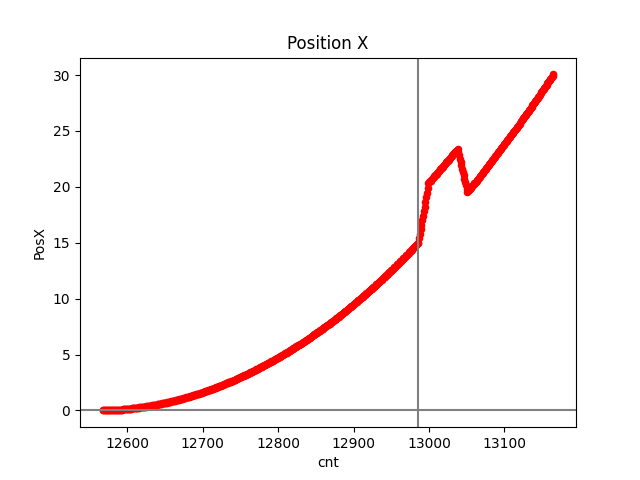

<IPython.core.display.Javascript object>


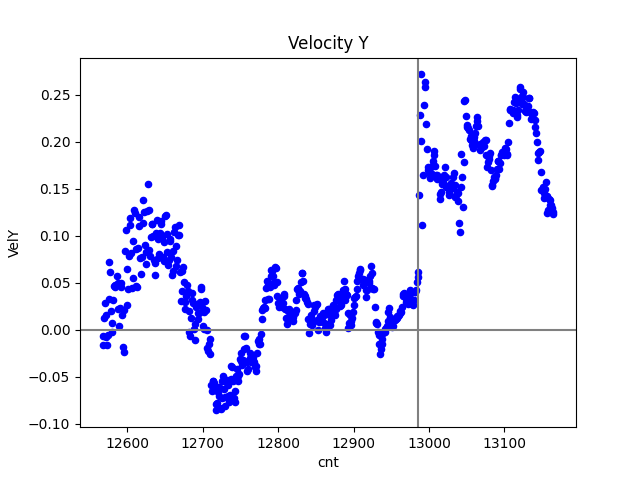

<IPython.core.display.Javascript object>


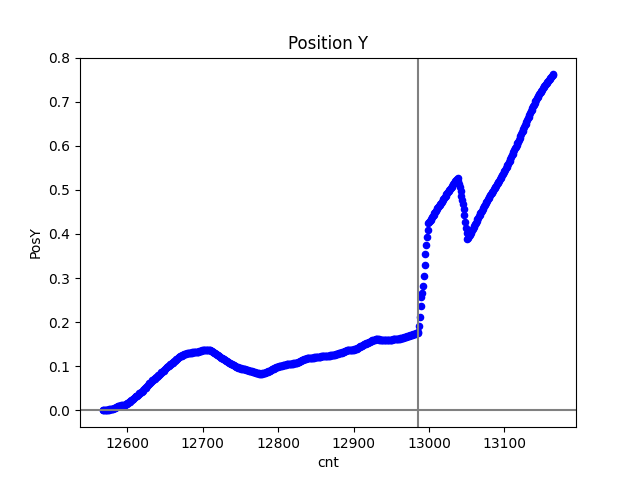

In [18]:
#in progress... calibrate & zero, then double integrate.

skiprows = 153 #found from the plots above
#skiprows += 1 #you could also re-run this same cell and incriment the skiprows each time (just a easy way to find the best fit)
#skiprows -= 1
rowcount = 600

#just playing around with non-zero lateral velocities at the start of the stroke
calibration["InitialVelX"] =  0.0100 #see the red plot below
calibration["InitialVelY"] = -0.0003 #see the blue plot below
calibration["InitialVelZ"] =  0 #obviously... we are trying to find the initial condition where Z is stopped

dfprocessed = ProcessData(df, calibration, skiprows=skiprows, rowcount=rowcount)

#get the localminima on the left half
rightlocalminidx = dfprocessed["PosZ"].iloc[int(rowcount/2):].idxmin()
minvelcnt = dfprocessed["cnt"][rightlocalminidx]
PlotDataProcessed(dfprocessed, True, vertline=minvelcnt)

In [19]:
dfprocessed.describe() #get some stats from the processed data. Checkout the max/min values for velocity & position

cnt       totalms    totalmsalt  mspersample    Sch  \
count    600.000000    600.000000    600.000000   600.000000  600.0   
mean   12865.500000   7605.393750   7727.186923    16.680641    1.0   
std      173.349358   2913.569339   2979.480032    16.034211    0.0   
min    12566.000000   2571.547500   2644.730769   -60.307692    1.0   
25%    12715.750000   5088.470625   5142.403846    16.692308    1.0   
50%    12865.500000   7605.393750   7640.346154    16.692308    1.0   
75%    13015.250000  10122.316875  10915.961538    16.692308    1.0   
max    13165.000000  12639.240000  12636.423077    93.615385    1.0   

             Press          Temp        Volt          AccX          AccY  ...  \
count   600.000000    600.000000   600.00000    600.000000    600.000000  ...   
mean   1006.708333  17735.886667  7980.82640  17738.638333  17856.673333  ...   
std       1.096327      0.891710     1.89777      9.929343     18.391947  ...   
min    1003.000000  17729.000000  7976.91000  17691.000000  17771.000000  ...   
25%    1006.000000  17736.000000  7978.44000  17733.000000  17847.000000  ...   
50%    1007.000000  17736.000000  7982.54000  17740.000000  17858.000000  ...   
75%    1008.000000  17736.000000  7982.54000  17745.000000  17867.000000  ...   
max    1008.000000  17742.000000  7983.06000  17781.000000  17942.000000  ...   

        VelDeltaZ        VelX        VelY        VelZ   PosDeltaX   PosDeltaY  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     0.000401    3.061823    0.073786    0.021375    0.050186    0.001272   
std      0.010023    1.759936    0.085907    0.128478    0.079094    0.003524   
min     -0.038761   -0.014312   -0.085766   -0.114864   -0.299990   -0.014766   
25%     -0.004330    1.535592    0.013048   -0.076179    0.023296    0.000185   
50%     -0.000457    3.004577    0.045815   -0.044993    0.048155    0.000716   
75%      0.004276    4.685327    0.150168    0.197146    0.078209    0.002427   
max      0.130159    6.068756    0.271607    0.255249    0.424638    0.025427   

        PosDeltaZ        PosX        PosY        PosZ  
count  599.000000  599.000000  599.000000  599.000000  
mean     0.000323   10.524357    0.233538   -0.174416  
std      0.003686    9.331191    0.208212    0.144065  
min     -0.014115   -0.000239   -0.000389   -0.422003  
25%     -0.001309    2.021291    0.101036   -0.318077  
50%     -0.000828    7.673009    0.132733   -0.177354  
75%      0.003291   20.481337    0.428604   -0.062765  
max      0.022766   30.061691    0.762029    0.193282  

[8 rows x 33 columns]

In [20]:
df.describe() #get some stats from the original unprocessed data

cnt       totalms    totalmsalt  mspersample    Sch  \
count    800.0000    800.000000    800.000000   800.000000  800.0   
mean   12812.5000   6714.596250   6820.969375    16.807500    1.0   
std      231.0844   3883.951056   3919.192615    14.682304    0.0   
min    12413.0000      0.000000      0.000000   -60.307692    1.0   
25%    12612.7500   3357.298125   3424.096154    16.692308    1.0   
50%    12812.5000   6714.596250   6756.384615    16.692308    1.0   
75%    13012.2500  10071.894375  10888.769231    16.692308    1.0   
max    13212.0000  13429.192500  13337.500000   108.500000    1.0   

             Press          Temp         Volt          AccX          AccY  \
count   800.000000    800.000000   800.000000    800.000000    800.000000   
mean   1006.688750  17736.095000  7980.814213  17738.592500  17856.487500   
std       1.129588      1.630736     1.900096     11.222472     20.701704   
min    1001.000000  17728.000000  7976.910000  17666.000000  17728.000000   
25%    1006.000000  17736.000000  7978.440000  17733.000000  17845.000000   
50%    1007.000000  17736.000000  7982.540000  17740.000000  17857.000000   
75%    1008.000000  17736.000000  7982.540000  17745.000000  17868.000000   
max    1008.000000  17742.000000  7983.060000  17798.000000  17942.000000   

              AccZ          Str1          Str2          Str3     dt_diff  
count   800.000000    800.000000    800.000000    800.000000  799.000000  
mean   9758.531250  10158.973750  11561.982500  10808.356250    0.016829  
std       8.545045      5.206433      6.694828     18.503238    0.076677  
min    9737.000000  10144.000000  11548.000000  10779.000000   -0.784000  
25%    9752.000000  10155.000000  11557.000000  10795.000000    0.000000  
50%    9757.000000  10159.000000  11561.000000  10801.000000    0.000000  
75%    9765.000000  10163.000000  11566.000000  10817.000000    0.000000  
max    9808.000000  10173.000000  11591.000000  10858.000000    1.217000

## ------------------------------ DONE -----------------------------------------------

Everything below here is just experimentation (well, I suppose the whole thing is... this is just leftover code for now)

Now we can plot the data. matplotlib is a bit more interactive when run locally, but this should be good enough for now.
Just plot the individual components to get an overview.

<IPython.core.display.Javascript object>


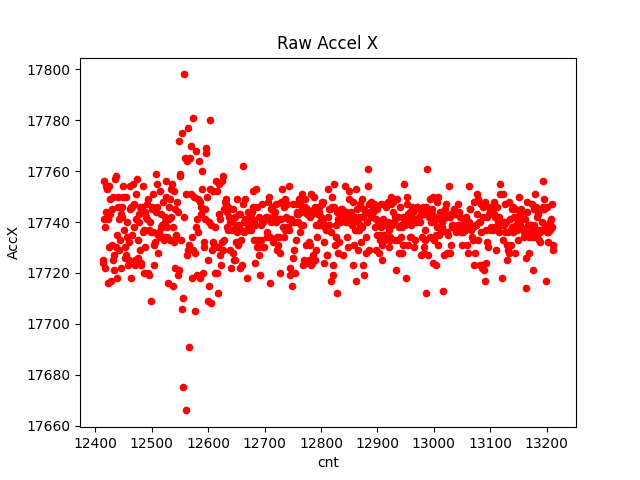

<IPython.core.display.Javascript object>


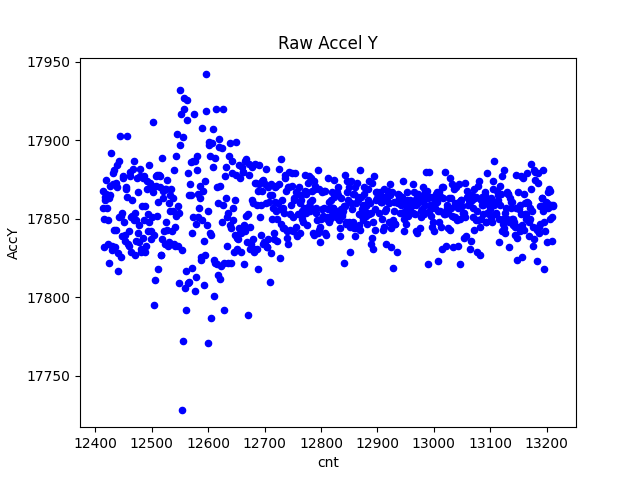

<IPython.core.display.Javascript object>


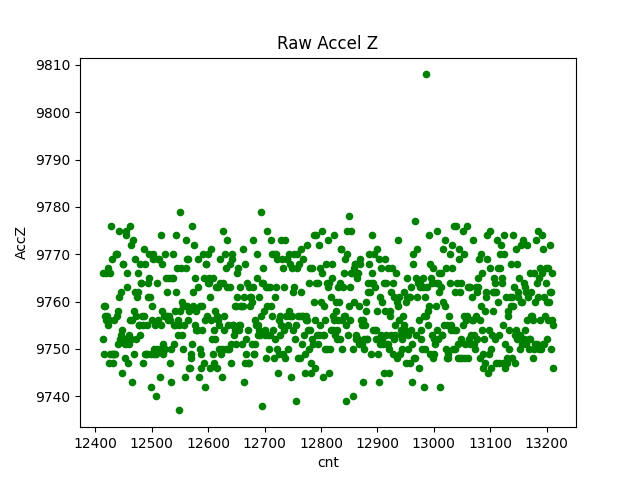

In [21]:
df.plot(kind="scatter", x="cnt", y="AccX", title="Raw Accel X", color="red")
plt.show()
df.plot(kind="scatter", x="cnt", y="AccY", title="Raw Accel Y", color="blue")
plt.show()
df.plot(kind="scatter", x="cnt", y="AccZ", title="Raw Accel Z", color="green")
plt.show()

TODO: Fix this stuff below

Lets get the gravity vector now. This should also be the direction of tool travel. Ideally, the samples that are not part of normal motion should have been eliminated above, and we should have enough samples to wash out partial strokes at the beginning/end.

In [22]:
gravityv = vmath.Vector3(df["AccX"].mean(), df["AccY"].mean(), df["AccZ"].mean())
print("Gravity vector:", gravityv)

#not sure if these next few lines are needed....

#I suck at python, but this should be an array of x,y,z vectors
arrxyz = np.reshape((np.array(df["AccX"]), np.array(df["AccY"]), np.array(df["AccZ"])), (3, -1)).transpose()


#load them into a Vector3Array to operate on
v_array = vmath.Vector3Array(arrxyz)

Gravity vector: [17738.5925  17856.4875   9758.53125]


Give a 3D view of that gravity vector... should roughly indicate the orientation of the tool.

In [23]:
pg = pv.Plotter()
pg.set_background("gray")
veczero = np.array([0., 0., 0.])

#TODO: probably want to orient these so direction of travel is up/down on this plot
vecgrav = np.array([calibration["AccelMeanX"], calibration["AccelMeanY"], calibration["AccelMeanZ"]])
gravline = np.stack((veczero, vecgrav))
_ = pg.add_lines(gravline, color="red") #notebook doesnt like line colors

#print("Average vector (represents gravity):", vecgrav)

#because I cant figure out how to plot the proper grid in pyvista. This is a bit hacky.
vertline = np.stack((veczero, np.array([0., 0., 1.])))
_ = pg.add_lines(vertline, color="blue")

horiline = np.stack((np.array([-1., 0., 0.]), np.array([1., 0., 0.])))
_ = pg.add_lines(horiline, color="blue")

horiline = np.stack((np.array([0., -1., 0.]), np.array([0., 1., 0.])))
_ = pg.add_lines(horiline, color="green")

#_ = pg.add_axes(interactive=True, color="blue") #notebook doesnt render helper
_ = pg.show_bounds(grid="front", location="outer", all_edges=True, color="red")
#_ = pg.show_grid() #not working?

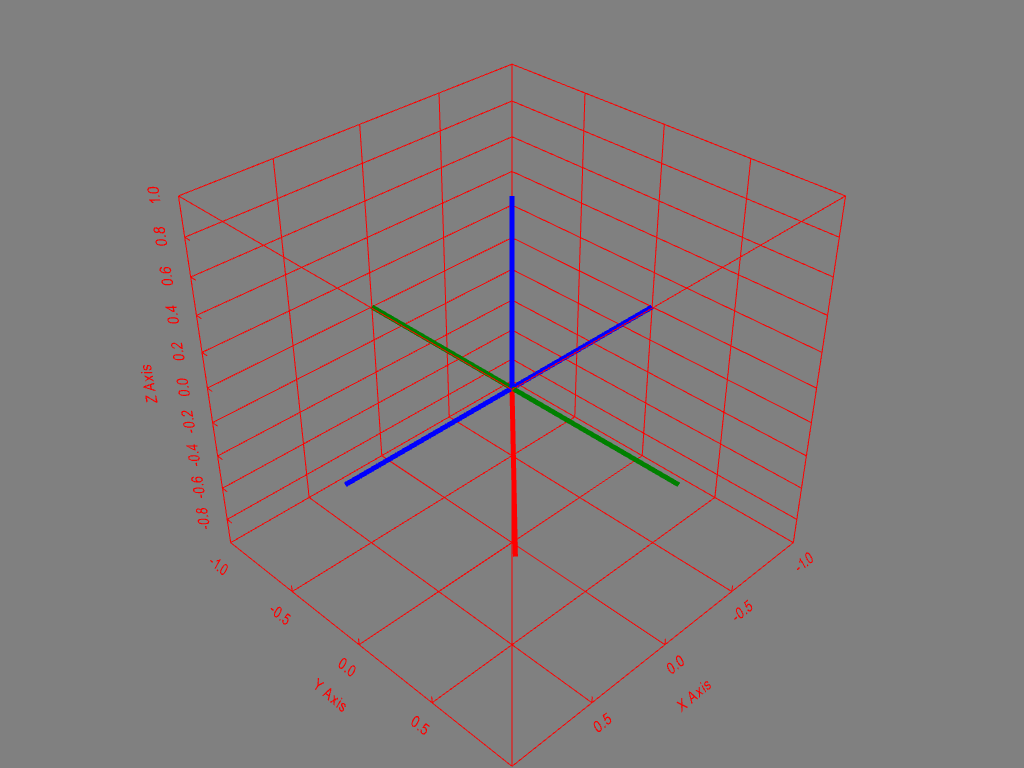

In [24]:
#this should show the orientation relative to true vertical. This could be due to misalignment or incorrect/incomplete average.
pg.show()

## TODO: should apply calibration to the raw sample data

Just plot all acceleration samples. Not too helpful at this point.

In [25]:
p = pv.Plotter()
p.set_background("gray")

verts = np.column_stack((df["AccX"], df["AccY"], df["AccZ"]))
_ = p.add_points(verts, color="red")
_ = p.add_axes()

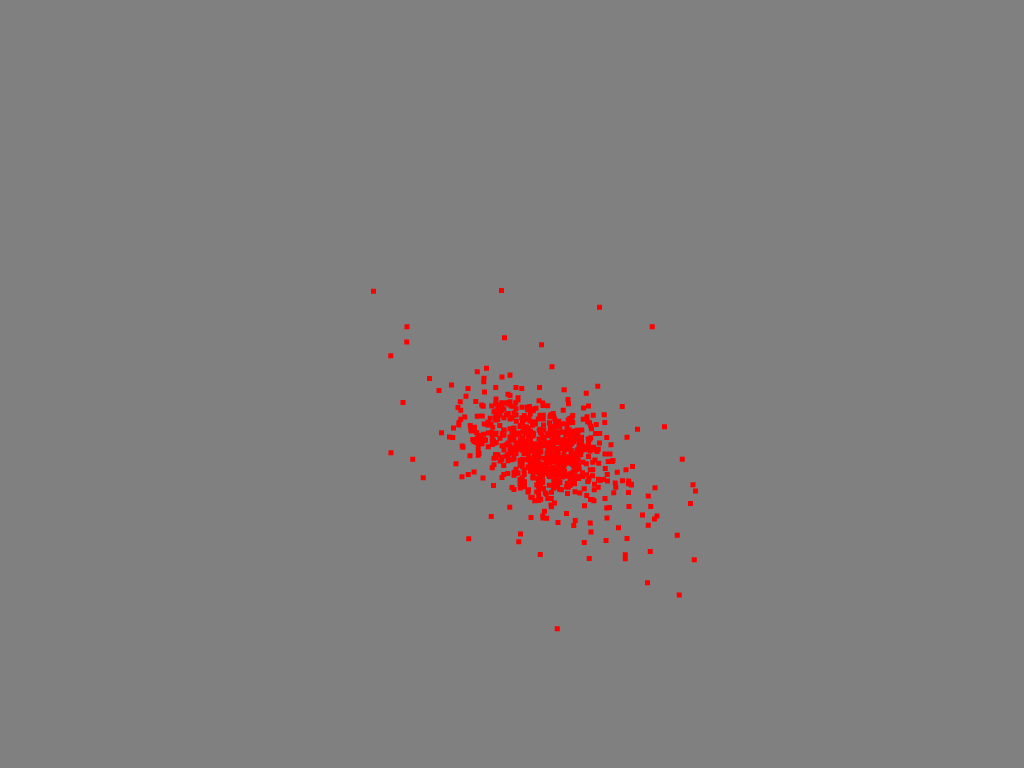

In [26]:
p.show()

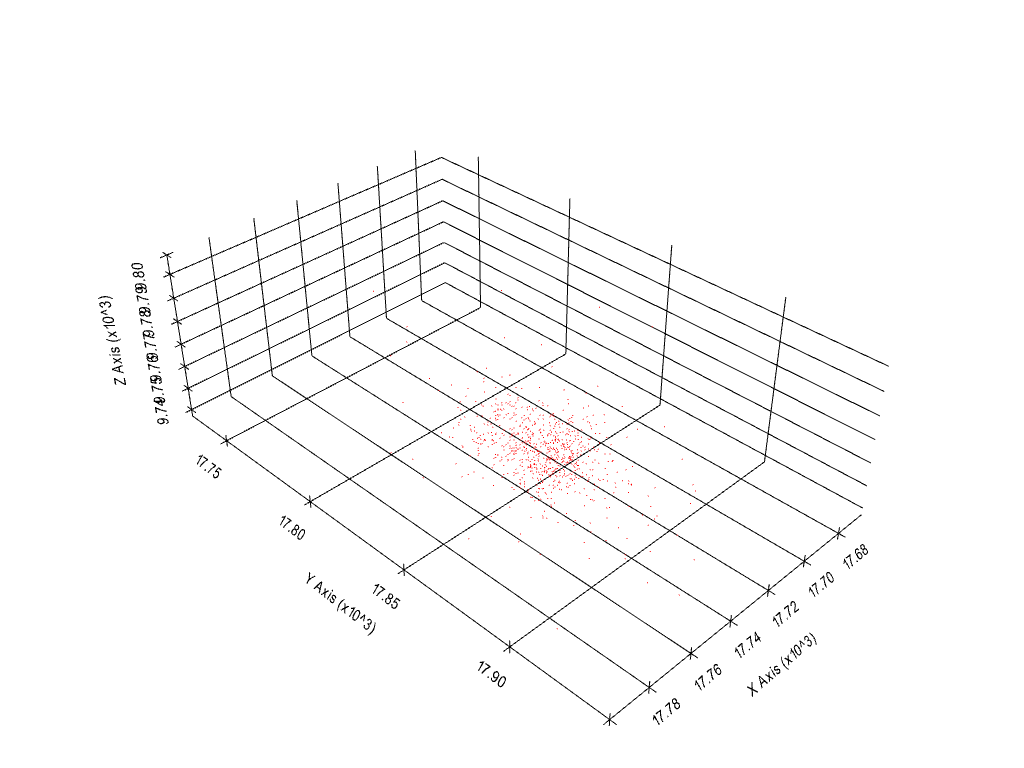

In [27]:
pc = pv.PolyData(verts)
pc.plot(point_size=1, show_grid=True, color="red")

In [28]:
print("test")

test
